In [1]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-11-30 18:42:41.651218: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-11-30 18:42:41.674026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 18:42:41.674287: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.71GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-11-30 18:42:41.674409: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-11-30 18:42:41.675443: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-11-30 18:42:41.676420: I tensorflow/stream_executor/platform/de

# Fully Custom Networks with TensorFlow and Proximal Policy Oprimization

In this tutorial you will learn how to configure you own custon neural network in the most versatile way. You may need to know some TensorFlow to be able to do an extension of one of our neural models and create your own computation graph. 

We use for this example the Proximal Policy Optimization (PPO) agent.

In [1]:
import tensorflow as tf
from RL_Problem import rl_problem
from RL_Agent import ppo_agent_discrete
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from RL_Agent.base.utils import agent_saver, history_utils
from RL_Agent.base.utils.networks.agent_networks import PPONet, TrainingHistory
from RL_Agent.base.utils.networks import networks, losses, returns_calculations

import gym


2021-12-01 12:53:08.769332: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-12-01 12:53:08.792785: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2799925000 Hz
2021-12-01 12:53:08.793507: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55ed892773f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-01 12:53:08.793522: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-12-01 12:53:08.793824: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/serch/anaconda3/envs/capoir/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
 

## Create the custom network

To create your own neural network It must extent the "RLNetInterfaz" from RL_Agent.base.utils.networks.networks_interface. This interfaz contains the minimun and mandatory parameter and funtions that a network need to work within the library. In RL_Agent.base.utils.networks.networks_interface we also have th "RLNetModel" class which extend "RLNetInterfaz" and contains some implementation of common functionalities, so create your nerwork extending from "RLNetModel" will be easier than extending from the interfaz.

In this tutorial we are going to extend the "PPONet" from "RL_Agent.utils.network.agent_networks" which already extend "RLNetModel" and cotains all the funtionalities that PPO needs. We recomend to extend from the classes implemented in "RL_Agent.utils.network.agent_networks" if you plan to use a default RL agent from this library and extend from "RLNetModel" if you pretend to make a deep modification of an agent or implementing a new one.

### Modification to PPONet

Here we explain the modification that we are going to make to the default PPO network.

#### Tensorboar summaries

We want to change the information recorded with tensorboard, so we need to reimplement our own funtions to write the summaries and assing they to the functions from the class:
* self.loss_sumaries: Write information related to the loss caculation.
* self.rl_loss_sumaries: Write information related to auxiliar data used in loss and metrics calculation.
* self.rl_sumaries: Write information related to the RL process like reward over epochs or epsilon values over epochs.

These three functions have their default implementation in "RL_Agent.utils.network.tensor_board_loss_functions.py"
and receives as inputs:

* data: List of values to write in the summary.
* names: List of sumary names for each value contained in data.
* step: Current step of the training process. We usually use the episodes



In [2]:
def custom_loss_sumaries(loss, names, step):
    if isinstance(loss, list):
        with tf.name_scope('Losses'):
            for l, n in zip(loss, names):
                tf.summary.scalar(n, l, step=step)

def custom_rl_loss_sumaries(data, names, step):
    with tf.name_scope('RL_Values'):
        for d, n in zip(data, names):
            with tf.name_scope(n):
                tf.summary.histogram('histogram', d, step=step)
                tf.summary.scalar('mean', tf.reduce_mean(d), step=step)
                tf.summary.scalar('std', tf.math.reduce_std(d), step=step)
                tf.summary.scalar('max', tf.reduce_max(d), step=step)
                tf.summary.scalar('min', tf.reduce_min(d), step=step)

def custom_rl_sumaries(data, names, step):
    with tf.name_scope('RL'):
        for d, n in zip(data, names):
            with tf.name_scope(n):
                tf.summary.scalar(n, d, step=step)


#### Actor-Critic Neural Network modifications

As we are using an Actor-Critic network we initialy need to define two networks: 1) self.actor_net and 2) self.critic_net. But, in this example, we want to implement only just one neural network to process the input data with two output heads, one for the Actor and one for the Critic. To this end, we are going to define just a single network, but this deep modification will force us to re-implement the prediction and training methods.

We will use the self.actor_net param to aour single network to avoid make modifications of some other functionalities due to a name change. 

#### Optimizer and Loss Function

We redefined the "compile" method to define our prefered optimizer instead of the defaul one and we select that we want to use the ppo loss for discrete action spaces (this is the default loss but here we can specify another diferent loss).

#### Train and Predict

We have modified the predict method in order to return only the actions and not the state values as the original one does. We also have modified the _predict_values method because it made use of the ctitic network.

Finally, we have modified the _train_step method to use only one network and remove the calls to the original variable "self.crtitic_net" that we do not already need. 

In [3]:
class CustomNet(PPONet):
    def __init__(self, input_shape, tensorboard_dir=None):
        super().__init__(actor_net=self._build_net(input_shape), 
                         critic_net=None, 
                         tensorboard_dir=tensorboard_dir)

        self.loss_sumaries = custom_loss_sumaries
        self.rl_loss_sumaries = custom_rl_loss_sumaries
        self.rl_sumaries = custom_rl_sumaries
        
        # Dummy variables for surrogate the critic variables that we do not need
        self.dummy_loss_critic = tf.Variable(0., tf.float32)
        variables_actor = self.actor_net.trainable_variables
        self.dummy_var_critic = [tf.Variable(tf.zeros(var.shape), tf.float32) for var in variables_actor]

    def _build_net(self, input_shape):
        input_data = Input(shape=input_shape)
        lstm = LSTM(64, activation='tanh')(input_data)
        dense1 = Dense(256, activation='relu')(lstm)
        dense2 = Dense(256, activation='relu')(dense1)

        # Actor head
        act_dense = Dense(128, activation='relu')(dense2)
        act_output = Dense(4, activation="softmax")(act_dense)
        
        # Critic Head
        critic_dense = Dense(64, activation='relu')(dense2)
        critic_output = Dense(1, activation="linear")(critic_dense)

        return tf.keras.models.Model(inputs=input_data, outputs=[act_output, critic_output])


    def compile(self, loss, optimizer, metrics=None):
        self.loss_func_actor = losses.ppo_loss_discrete
        self.loss_func_critic = None
        self.optimizer_actor = tf.keras.optimizers.RMSprop(1e-4)
        self.optimizer_critic = None
        self.calculate_advantages = returns_calculations.gae
        self.metrics = metrics

    def predict(self, x):
        y_ = self._predict(x)
        return y_[0].numpy()
    
    @tf.function(experimental_relax_shapes=True)
    def _predict_values(self, x):
        y_ = self.actor_net(tf.cast(x, tf.float32), training=False)
        return y_[1]
    
    @tf.function(experimental_relax_shapes=True)
    def _train_step(self, x, old_prediction, y, returns, advantages, stddev=None, loss_clipping=0.3,
                   critic_discount=0.5, entropy_beta=0.001):
        with tf.GradientTape() as tape:
            y_ = self.actor_net(x, training=True)
            loss_actor, loss_complement_values = self.loss_func_actor(y, y_[0], advantages, old_prediction, returns, y_[1], stddev, loss_clipping,
                                  critic_discount, entropy_beta)

        variables_actor = self.actor_net.trainable_variables
        gradients_actor = tape.gradient(loss_actor, variables_actor)
        self.optimizer_actor.apply_gradients(zip(gradients_actor, variables_actor))

        return [loss_actor, self.dummy_loss_critic], [gradients_actor, self.dummy_var_critic], [variables_actor, self.dummy_var_critic], returns, advantages, loss_complement_values



In the next cell, we define the network architecture dictionario in order to pass the neural model to the agent. We do this through a function that receives the input shape. Latter we create the dictionary setting "use_tf_custom_model" to True, which means that we are going to use a model extended ftom the "RLNetInterfaz". Then, we assing the function to create the model to "tf_custom_model".

When we set the neural network model through the "use_tf_custom_model" and "tf_custom_model" params we are required to define the output layers becaouse the "define_custom_output_layer" param will be overridden.

In [4]:
def custom_model_tf(input_shape):
    return CustomNet(input_shape=input_shape, tensorboard_dir='tensorboard_logs')

net_architecture = networks.ppo_net(use_tf_custom_model=True,
                                     tf_custom_model=custom_model_tf)

In [5]:
agent = ppo_agent_discrete.Agent(batch_size=64,
                                 memory_size=500,
                                 epsilon=0.7,
                                 epsilon_decay=0.97,
                                 epsilon_min=0.15,
                                 net_architecture=net_architecture,
                                 n_stack=4)


In [6]:
environment = "LunarLander-v2"
environment = gym.make(environment)

In [7]:
problem = rl_problem.Problem(environment, agent)

In [8]:
problem.solve(200, render=False, max_step_epi=200, render_after=2090, skip_states=1)

Test episode:  1 Epochs:  54  Reward: -269.0 Smooth Reward: -269.0  Epsilon: 0.7000
Test episode:  2 Epochs:  65  Reward: -481.0 Smooth Reward: -375.0  Epsilon: 0.7000
Test episode:  3 Epochs:  56  Reward: -370.5 Smooth Reward: -373.5  Epsilon: 0.7000
Test episode:  4 Epochs:  82  Reward: -737.2 Smooth Reward: -464.4  Epsilon: 0.7000
Episode:  2 Epochs:  77  Reward: -386.1 Smooth Reward: -386.1  Epsilon: 0.7000
Episode:  3 Epochs:  81  Reward: -440.7 Smooth Reward: -413.4  Epsilon: 0.7000
Episode:  4 Epochs:  84  Reward: -509.3 Smooth Reward: -475.0  Epsilon: 0.7000
Episode:  5 Epochs:  81  Reward: -207.7 Smooth Reward: -358.5  Epsilon: 0.7000
Episode:  6 Epochs:  81  Reward: -517.3 Smooth Reward: -362.5  Epsilon: 0.7000
Episode:  7 Epochs:  70  Reward: -354.1 Smooth Reward: -435.7  Epsilon: 0.7000
Episode:  8 Epochs:  78  Reward: -427.6 Smooth Reward: -390.8  Epsilon: 0.7000
Actor loss 932.9331 0
Critic loss 0.0 0
Episode:  9 Epochs:  65  Reward: -97.8 Smooth Reward: -262.7  Epsilon: 

Episode:  94 Epochs:  62  Reward: -336.9 Smooth Reward: -274.0  Epsilon: 0.4711
Episode:  95 Epochs:  69  Reward: -393.4 Smooth Reward: -365.2  Epsilon: 0.4711
Episode:  96 Epochs:  93  Reward: -534.3 Smooth Reward: -463.9  Epsilon: 0.4711
Episode:  97 Epochs:  87  Reward: -329.8 Smooth Reward: -432.0  Epsilon: 0.4711
Episode:  98 Epochs:  71  Reward: -518.3 Smooth Reward: -424.0  Epsilon: 0.4711
Actor loss 40.149982 13
Critic loss 0.0 13
Episode:  99 Epochs:  107  Reward: -17.4 Smooth Reward: -267.9  Epsilon: 0.4570
Episode:  100 Epochs:  62  Reward: -398.5 Smooth Reward: -208.0  Epsilon: 0.4570
Test episode:  1 Epochs:  66  Reward: -66.1 Smooth Reward: -66.1  Epsilon: 0.4570
Test episode:  2 Epochs:  82  Reward: -63.3 Smooth Reward: -64.7  Epsilon: 0.4570
Test episode:  3 Epochs:  86  Reward: -94.4 Smooth Reward: -74.6  Epsilon: 0.4570
Test episode:  4 Epochs:  81  Reward: -54.5 Smooth Reward: -69.6  Epsilon: 0.4570
Episode:  101 Epochs:  93  Reward: -222.8 Smooth Reward: -310.6  Eps

Episode:  185 Epochs:  117  Reward: -587.6 Smooth Reward: -544.9  Epsilon: 0.3076
Episode:  186 Epochs:  81  Reward: -489.0 Smooth Reward: -538.3  Epsilon: 0.3076
Episode:  187 Epochs:  207  Reward: -713.1 Smooth Reward: -601.1  Epsilon: 0.3076
Actor loss 71.73188 27
Critic loss 0.0 27
Episode:  188 Epochs:  197  Reward: -590.6 Smooth Reward: -651.8  Epsilon: 0.2983
Episode:  189 Epochs:  295  Reward: -346.0 Smooth Reward: -468.3  Epsilon: 0.2983
Episode:  190 Epochs:  118  Reward: -582.8 Smooth Reward: -464.4  Epsilon: 0.2983
Actor loss 27.017988 28
Critic loss 0.0 28
Episode:  191 Epochs:  80  Reward: -592.0 Smooth Reward: -587.4  Epsilon: 0.2894
Episode:  192 Epochs:  113  Reward: -612.1 Smooth Reward: -602.0  Epsilon: 0.2894
Episode:  193 Epochs:  164  Reward: -402.4 Smooth Reward: -507.2  Epsilon: 0.2894
Episode:  194 Epochs:  129  Reward: -465.9 Smooth Reward: -434.1  Epsilon: 0.2894
Episode:  195 Epochs:  73  Reward: -447.4 Smooth Reward: -456.7  Epsilon: 0.2894
Actor loss 105.3

In [9]:
problem.test(render=True, n_iter=10)

Test episode:  1 Epochs:  97  Reward: -45.7 Smooth Reward: -45.7  Epsilon: 0.2641
Test episode:  2 Epochs:  75  Reward: -293.0 Smooth Reward: -169.3  Epsilon: 0.2641
Test episode:  3 Epochs:  122  Reward: -137.6 Smooth Reward: -158.7  Epsilon: 0.2641
Test episode:  4 Epochs:  78  Reward: -55.0 Smooth Reward: -132.8  Epsilon: 0.2641
Test episode:  5 Epochs:  100  Reward: -146.0 Smooth Reward: -135.4  Epsilon: 0.2641
Test episode:  6 Epochs:  75  Reward: -73.6 Smooth Reward: -125.1  Epsilon: 0.2641
Test episode:  7 Epochs:  106  Reward: -145.3 Smooth Reward: -128.0  Epsilon: 0.2641
Test episode:  8 Epochs:  114  Reward: -173.8 Smooth Reward: -133.7  Epsilon: 0.2641
Test episode:  9 Epochs:  115  Reward: -76.9 Smooth Reward: -127.4  Epsilon: 0.2641
Test episode:  10 Epochs:  88  Reward: -122.9 Smooth Reward: -127.0  Epsilon: 0.2641


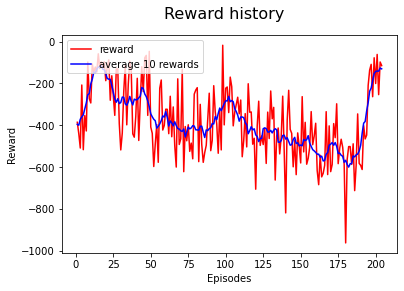

In [10]:
hist = problem.get_histogram_metrics()
history_utils.plot_reward_hist(hist, 10)

In [ ]:
!tensorboard --logdir=tensorboard_logs

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.2.0 at http://localhost:6006/ (Press CTRL+C to quit)
